In [1]:
import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize,ToTensor, Normalize, Compose
from torchvision.datasets import ImageFolder
import imageio

import natsort
import os
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def visualize(df, index=0):
    """
    Visualizes image
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(df[index][0][0], cmap='gray')
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(df[index][1][0],cmap='gray')
    plt.title('Segmented Image')
    plt.show()

In [5]:
class Dataset(Dataset):
    
    
    def __init__(self, x_dir, y_dir, transform):
        self.x_dir = x_dir
        self.y_dir = y_dir
        self.transform = transform
        x_imgs = os.listdir(x_dir)
        y_imgs = os.listdir(y_dir)
        self.x_imgs = natsort.natsorted(x_imgs)
        self.y_imgs = natsort.natsorted(y_imgs)
        
        if len(x_imgs) != len(y_imgs):
            raise("X and Y image folders have different number of files.")

    def __len__(self):
        return len(self.x_imgs)

    def __getitem__(self, idx):
        
        img_loc = os.path.join(self.x_dir, self.x_imgs[idx])
        image = imageio.imread(img_loc)
        if image.ndim == 3:
            image = 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]
        x_tensor_image = self.transform(image)
        
        img_loc = os.path.join(self.y_dir, self.y_imgs[idx])
        image = imageio.imread(img_loc)
        if image.ndim == 3:
            image = 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]
        y_tensor_image = self.transform(image)
        
        
        return x_tensor_image.float()/x_tensor_image.max(), y_tensor_image.float()/y_tensor_image.max()                      
        
        

In [6]:
raw_image_dir = Path("/content/drive/MyDrive/datasets/line_seg/processed/")
seg_image_dir = Path("/content/drive/MyDrive/datasets/line_seg/seg_mask/")

df = Dataset(raw_image_dir, seg_image_dir, transform = Compose([ToTensor(), Resize((512,512))]))

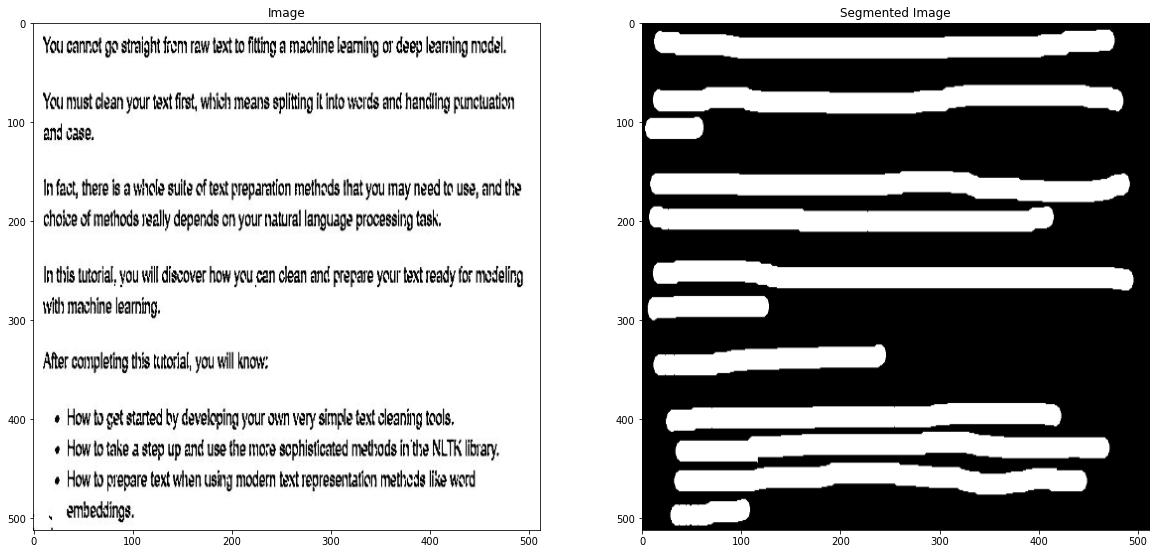

In [7]:
visualize(df, 60)

## Neural Network

In [8]:
class Unet(nn.Module):

    def __init__(self):
        super(Unet, self).__init__()
            
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.pool1  = nn.MaxPool2d((2,2))
            
        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv4 = nn.Conv2d(128, 128, 3, padding='same')
        self.pool2  = nn.MaxPool2d((2,2))
            
        self.conv5 = nn.Conv2d(128, 256, 3, padding='same')
        self.conv6 = nn.Conv2d(256, 256, 3, padding='same')
        self.pool3  = nn.MaxPool2d((2,2))
            
        self.conv7 = nn.Conv2d(256, 512, 3, padding='same')
        self.conv8 = nn.Conv2d(512, 512, 3, padding='same')
        self.dropout1 = nn.Dropout(0.5)
        self.pool4 = nn.MaxPool2d((2,2))
            
        self.conv9 = nn.Conv2d(512, 1024, 3, padding='same')
        self.conv10 = nn.Conv2d(1024, 1024, 3, padding='same')
        self.dropout2 = nn.Dropout(0.5)
                   
        self.conv11 = nn.Conv2d(1024, 512, 2, padding='same')
        self.conv12 = nn.Conv2d(1024, 512, 3, padding='same')
        self.conv13 = nn.Conv2d(512, 512, 3, padding='same')
        
        self.conv14 = nn.Conv2d(512, 256, 2, padding='same')
        self.conv15 = nn.Conv2d(512, 256, 3, padding='same')
        self.conv16 = nn.Conv2d(256, 256, 3, padding='same')

        self.conv17 = nn.Conv2d(256, 128, 2, padding='same')
        self.conv18 = nn.Conv2d(256, 128, 3, padding='same')
        self.conv19 = nn.Conv2d(128, 128, 3, padding='same')

        self.conv20 = nn.Conv2d(128, 64, 2, padding='same')
        self.conv21 = nn.Conv2d(128, 64, 3, padding='same')
        self.conv22 = nn.Conv2d(64, 64, 3, padding='same')

        self.conv23 = nn.Conv2d(64, 2, 3, padding='same')
        
        self.conv24 = nn.Conv2d(2, 1, 1, padding='same')
        
        self.merge = lambda x,y : torch.cat((x, y), 1)
        self.upsample = nn.Upsample(scale_factor=2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() 
            
            
    def foward(self, x):
        
        inputs = x
        
        conv1 = self.relu(self.conv1(inputs))
        conv2 = self.relu(self.conv2(conv1))
        pool1 = self.pool1(conv2)
        
        conv3 = self.relu(self.conv3(pool1))
        conv4 = self.relu(self.conv4(conv3))
        pool2 = self.pool2(conv4)
        
        conv5 = self.relu(self.conv5(pool2))
        conv6 = self.relu(self.conv6(conv5))
        pool3 = self.pool3(conv6)
        
        conv7 = self.relu(self.conv7(pool3))
        conv8 = self.relu(self.conv8(conv7))
        drop1 = self.dropout1(conv8)
        pool4 = self.pool4(drop1)

        conv9 = self.relu(self.conv9(pool4))
        conv10 = self.relu(self.conv10(conv9))
        drop2 = self.dropout2(conv10)
        
        conv11 = self.relu(self.conv11(self.upsample(drop2)))
        merge1 = self.merge(drop1, conv11)
        conv12 = self.relu(self.conv12(merge1))
        conv13 = self.relu(self.conv13(conv12))
        
        conv14 = self.relu(self.conv14(self.upsample(conv13)))
        merge2 = self.merge(conv6, conv14)
        conv15  = self.relu(self.conv15(merge2))
        conv16  = self.relu(self.conv16(conv15))
        
        conv17 = self.relu(self.conv17(self.upsample(conv16)))
        merge3 = self.merge(conv4, conv17)
        conv18 = self.relu(self.conv18(merge3))
        conv19 = self.relu(self.conv19(conv18))
        
        conv20 = self.relu(self.conv20(self.upsample(conv19)))
        merge4 = self.merge(conv2, conv20)
        conv21 = self.relu(self.conv21(merge4))
        conv22 = self.relu(self.conv22(conv21))
        
        conv23 = self.relu(self.conv23(conv22))
        
        output = self.sigmoid(self.conv24(conv23))
                
        return output


    def weight_init(self):
        if isinstance(self, nn.Conv2d) or isinstance(self, nn.Linear):
            nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('nn.ReLU'))
            nn.init.zeros_(self.bias)

model = Unet()
#model.apply(weight_init)

In [9]:
epochs = 40
batch_size = 4
data_loader = DataLoader(df, batch_size, shuffle=True)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
model.to(device)
losses = []
for epoch in range(1,epochs+1):
  print('EPOCH {}:'.format(epoch))
  running_loss = []
  for i, data in enumerate(data_loader):
      optimizer.zero_grad()
      
      x, y = data

      x=x.to(device)
      y=y.to(device)

      y_pred = model.foward(x)

      loss = criterion(y_pred, y)
      
      running_loss.append(loss.item())

      loss.backward()
      optimizer.step()

  losses.append(np.mean(running_loss))
  print(' LOSS:', np.mean(running_loss))

EPOCH 1:


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:444: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


In [ ]:
plt.plot(range(1,len(losses)+1),losses)

In [ ]:
plt.imshow(y[0][0].detach().cpu(), cmap='gray')

In [ ]:
plt.imshow(y_pred[0][0].detach().cpu(), cmap='gray')